In [29]:
import pandas as pd
from rdkit import Chem
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


In [30]:
df = pd.read_csv('../data/tox21.csv')
df

,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,mol_id,smiles
0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3020,CCN1C(=O)NC(c2ccccc2)C1=O
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,TOX3024,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3027,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
4,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,TOX3028,CC(O)(P(=O)(O)O)P(=O)(O)O
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,TOX2725,CCOc1nc2cccc(C(=O)O)c2n1Cc1ccc(-c2ccccc2-c2nnn...
8002,1.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,TOX2370,CC(=O)[C@H]1CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@]4(...
8003,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX2371,C[C@]12CC[C@H]3[C@@H](CCC4=CC(=O)CC[C@@]43C)[C...
8004,1.0,1.0,0.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,TOX2377,C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1CC[C...


In [153]:
df['NR-AR'].value_counts()

NR-AR
0.0    7123
1.0     309
Name: count, dtype: int64

### For Visualisation

In [204]:
def convert_smiles_to_mol_graph(smiles):
    # Convert SMILES to RDKit Mol object
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError(f"Invalid SMILES: {smiles}")

    # Initialize graph
    G = nx.Graph()

    # Add atoms as nodes
    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx(), element=atom.GetSymbol())

    # Add bonds as edges
    for bond in mol.GetBonds():
        start_atom = bond.GetBeginAtomIdx()
        end_atom = bond.GetEndAtomIdx()
        bond_type = bond.GetBondType()
        G.add_edge(start_atom, end_atom, bond_type=str(bond_type))

    return G

In [205]:
graph = convert_smiles_to_mol_graph('COc1ccc2c(c1OC)CN1CCc3cc4c(cc3C1C2)OCO4')

In [206]:
print(len(graph))

25


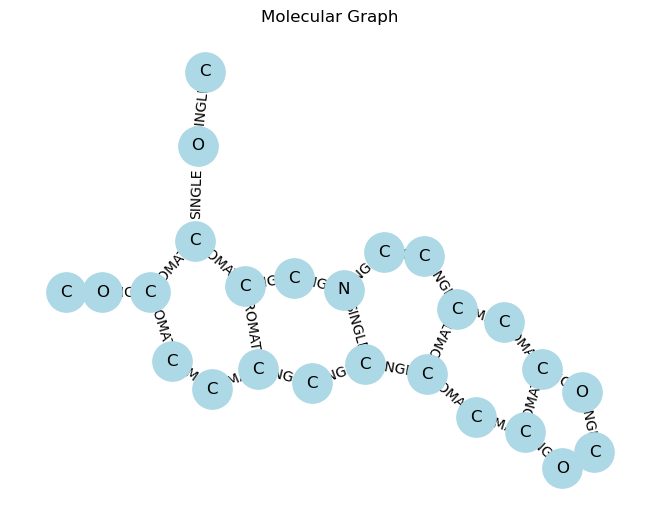

In [211]:
# Visualize the graph
pos = nx.spring_layout(graph)
labels = nx.get_node_attributes(graph, 'element')
nx.draw(graph, pos, with_labels=True, labels=labels, node_size=800, node_color="lightblue")
edge_labels = nx.get_edge_attributes(graph, 'bond_type')
nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
plt.title("Molecular Graph")
plt.show()

### For Graph Neural Network

In [59]:
import numpy as np
# RDkit
from rdkit import Chem
from rdkit.Chem.rdmolops import GetAdjacencyMatrix
# Pytorch and Pytorch Geometric
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

In [60]:
def one_hot_encoding(x, permitted_list):
    """
    Maps input elements x which are not in the permitted list to the last element
    of the permitted list.
    """
    if x not in permitted_list:
        x = permitted_list[-1]
    binary_encoding = [int(boolean_value) for boolean_value in list(map(lambda s: x == s, permitted_list))]
    return binary_encoding

In [61]:
def get_atom_features(atom, 
                      use_chirality = True, 
                      hydrogens_implicit = True):
    """
    Takes an RDKit atom object as input and gives a 1d-numpy array of atom features as output.
    """

    # define list of permitted atoms
    
    permitted_list_of_atoms =  ['C','N','O','S','F','Si','P','Cl','Br','Mg','Na','Ca','Fe','As','Al','I', 'B','V','K','Tl','Yb','Sb','Sn','Ag','Pd','Co','Se','Ti','Zn', 'Li','Ge','Cu','Au','Ni','Cd','In','Mn','Zr','Cr','Pt','Hg','Pb','Unknown']
    
    if hydrogens_implicit == False:
        permitted_list_of_atoms = ['H'] + permitted_list_of_atoms
    
    # compute atom features
    
    atom_type_enc = one_hot_encoding(str(atom.GetSymbol()), permitted_list_of_atoms)
    
    n_heavy_neighbors_enc = one_hot_encoding(int(atom.GetDegree()), [0, 1, 2, 3, 4, "MoreThanFour"])
    
    formal_charge_enc = one_hot_encoding(int(atom.GetFormalCharge()), [-3, -2, -1, 0, 1, 2, 3, "Extreme"])
    
    hybridisation_type_enc = one_hot_encoding(str(atom.GetHybridization()), ["S", "SP", "SP2", "SP3", "SP3D", "SP3D2", "OTHER"])
    
    is_in_a_ring_enc = [int(atom.IsInRing())]
    
    is_aromatic_enc = [int(atom.GetIsAromatic())]
    
    atomic_mass_scaled = [float((atom.GetMass() - 10.812)/116.092)]
    
    vdw_radius_scaled = [float((Chem.GetPeriodicTable().GetRvdw(atom.GetAtomicNum()) - 1.5)/0.6)]
    
    covalent_radius_scaled = [float((Chem.GetPeriodicTable().GetRcovalent(atom.GetAtomicNum()) - 0.64)/0.76)]

    atom_feature_vector = atom_type_enc + n_heavy_neighbors_enc + formal_charge_enc + hybridisation_type_enc + is_in_a_ring_enc + is_aromatic_enc + atomic_mass_scaled + vdw_radius_scaled + covalent_radius_scaled
                                    
    if use_chirality == True:
        chirality_type_enc = one_hot_encoding(str(atom.GetChiralTag()), ["CHI_UNSPECIFIED", "CHI_TETRAHEDRAL_CW", "CHI_TETRAHEDRAL_CCW", "CHI_OTHER"])
        atom_feature_vector += chirality_type_enc
    
    if hydrogens_implicit == True:
        n_hydrogens_enc = one_hot_encoding(int(atom.GetTotalNumHs()), [0, 1, 2, 3, 4, "MoreThanFour"])
        atom_feature_vector += n_hydrogens_enc

    return np.array(atom_feature_vector)

In [62]:
def get_bond_features(bond, 
                      use_stereochemistry = True):
    """
    Takes an RDKit bond object as input and gives a 1d-numpy array of bond features as output.
    """

    permitted_list_of_bond_types = [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE, Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC]

    bond_type_enc = one_hot_encoding(bond.GetBondType(), permitted_list_of_bond_types)
    
    bond_is_conj_enc = [int(bond.GetIsConjugated())]
    
    bond_is_in_ring_enc = [int(bond.IsInRing())]
    
    bond_feature_vector = bond_type_enc + bond_is_conj_enc + bond_is_in_ring_enc
    
    if use_stereochemistry == True:
        stereo_type_enc = one_hot_encoding(str(bond.GetStereo()), ["STEREOZ", "STEREOE", "STEREOANY", "STEREONONE"])
        bond_feature_vector += stereo_type_enc

    return np.array(bond_feature_vector)

In [63]:
def create_pytorch_geometric_graph_data_list_from_smiles_and_labels(x_smiles, y):
    """
    Inputs:
    
    x_smiles = [smiles_1, smiles_2, ....] ... a list of SMILES strings
    y = [y_1, y_2, ...] ... a list of numerial labels for the SMILES strings (such as associated pKi values)
    
    Outputs:
    
    data_list = [G_1, G_2, ...] ... a list of torch_geometric.data.Data objects which represent labeled molecular graphs that can readily be used for machine learning
    
    """
    
    data_list = []
    
    for (smiles, y_val) in zip(x_smiles, y):
        
        # convert SMILES to RDKit mol object
        mol = Chem.MolFromSmiles(smiles)

        # get feature dimensions
        n_nodes = mol.GetNumAtoms()
        n_edges = 2*mol.GetNumBonds()
        unrelated_smiles = "O=O"
        unrelated_mol = Chem.MolFromSmiles(unrelated_smiles)
        n_node_features = len(get_atom_features(unrelated_mol.GetAtomWithIdx(0)))
        n_edge_features = len(get_bond_features(unrelated_mol.GetBondBetweenAtoms(0,1)))

        # construct node feature matrix X of shape (n_nodes, n_node_features)
        X = np.zeros((n_nodes, n_node_features))

        for atom in mol.GetAtoms():
            X[atom.GetIdx(), :] = get_atom_features(atom)
            
        X = torch.tensor(X, dtype = torch.float)
        
        # construct edge index array E of shape (2, n_edges)
        (rows, cols) = np.nonzero(GetAdjacencyMatrix(mol))
        torch_rows = torch.from_numpy(rows.astype(np.int64)).to(torch.long)
        torch_cols = torch.from_numpy(cols.astype(np.int64)).to(torch.long)
        E = torch.stack([torch_rows, torch_cols], dim = 0)
        
        # construct edge feature array EF of shape (n_edges, n_edge_features)
        EF = np.zeros((n_edges, n_edge_features))
        
        for (k, (i,j)) in enumerate(zip(rows, cols)):
            
            EF[k] = get_bond_features(mol.GetBondBetweenAtoms(int(i),int(j)))
        
        EF = torch.tensor(EF, dtype = torch.float)
        
        # construct label tensor
        y_tensor = torch.tensor(np.array([y_val]), dtype = torch.float)
        
        # construct Pytorch Geometric data object and append to data list
        data_list.append(Data(x = X, edge_index = E, edge_attr = EF, y = y_tensor))

    return data_list

In [196]:
graph_data = create_pytorch_geometric_graph_data_list_from_smiles_and_labels(['COc1ccc2c(c1OC)CN1CCc3cc4c(cc3C1C2)OCO4'], [1])[0]

In [197]:
graph_data.num_node_features

79

In [215]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

class GCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, dropout_rate=0.3, dropout_location='none'):
        super().__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)

        self.fc1 = torch.nn.Linear(hidden_channels, hidden_channels // 2)
        self.fc2 = torch.nn.Linear(hidden_channels // 2, 2)

        self.dropout_rate = dropout_rate
        self.dropout_location = dropout_location.lower()

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))

        x = global_mean_pool(x, batch)
        if self.dropout_location in ['after_pool', 'both']:
            x = F.dropout(x, p=self.dropout_rate, training=self.training)

        x = self.fc1(x)
        x = F.relu(x)
        if self.dropout_location in ['after_fc1', 'both']:
            x = F.dropout(x, p=self.dropout_rate, training=self.training)

        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [ ]:
# now we train the model for each of the twelve classification tasks
from sklearn.model_selection import train_test_split

# define the targets
targets = ['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 
           'NR-ER-LBD', 'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 
           'SR-HSE', 'SR-MMP', 'SR-p53']

# define the number of epochs
num_epochs = 6

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(
                    num_node_features=79,
                    hidden_channels=256,
                    dropout_rate=0.2,
                    dropout_location='after_pool'
                ).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)


In [273]:
y = df['NR-AR']
mask = y.notna()
x_clean = df['smiles'][mask].to_list()
y_clean = y[mask].to_list()

In [287]:
x_train, x_test, y_train, y_test = train_test_split(x_clean, y_clean, test_size=0.2, random_state=42)

# create the dataset
train_dataset = create_pytorch_geometric_graph_data_list_from_smiles_and_labels(x_train, y_train)
test_dataset = create_pytorch_geometric_graph_data_list_from_smiles_and_labels(x_test, y_test)

# create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(train_dataset)
train_dataset[0].x

[00:44:28] WARNING: not removing hydrogen atom without neighbors


[Data(x=[21, 79], edge_index=[2, 38], edge_attr=[38, 10], y=[1]), Data(x=[26, 79], edge_index=[2, 54], edge_attr=[54, 10], y=[1]), Data(x=[12, 79], edge_index=[2, 24], edge_attr=[24, 10], y=[1]), Data(x=[4, 79], edge_index=[2, 6], edge_attr=[6, 10], y=[1]), Data(x=[15, 79], edge_index=[2, 32], edge_attr=[32, 10], y=[1]), Data(x=[25, 79], edge_index=[2, 56], edge_attr=[56, 10], y=[1]), Data(x=[15, 79], edge_index=[2, 30], edge_attr=[30, 10], y=[1]), Data(x=[58, 79], edge_index=[2, 126], edge_attr=[126, 10], y=[1]), Data(x=[5, 79], edge_index=[2, 8], edge_attr=[8, 10], y=[1]), Data(x=[14, 79], edge_index=[2, 28], edge_attr=[28, 10], y=[1]), Data(x=[38, 79], edge_index=[2, 84], edge_attr=[84, 10], y=[1]), Data(x=[24, 79], edge_index=[2, 54], edge_attr=[54, 10], y=[1]), Data(x=[17, 79], edge_index=[2, 34], edge_attr=[34, 10], y=[1]), Data(x=[21, 79], edge_index=[2, 42], edge_attr=[42, 10], y=[1]), Data(x=[5, 79], edge_index=[2, 8], edge_attr=[8, 10], y=[1]), Data(x=[8, 79], edge_index=[2, 

tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [288]:
print(train_dataset)
print(len(train_dataset))
print(len(test_dataset))

[Data(x=[21, 79], edge_index=[2, 38], edge_attr=[38, 10], y=[1]), Data(x=[26, 79], edge_index=[2, 54], edge_attr=[54, 10], y=[1]), Data(x=[12, 79], edge_index=[2, 24], edge_attr=[24, 10], y=[1]), Data(x=[4, 79], edge_index=[2, 6], edge_attr=[6, 10], y=[1]), Data(x=[15, 79], edge_index=[2, 32], edge_attr=[32, 10], y=[1]), Data(x=[25, 79], edge_index=[2, 56], edge_attr=[56, 10], y=[1]), Data(x=[15, 79], edge_index=[2, 30], edge_attr=[30, 10], y=[1]), Data(x=[58, 79], edge_index=[2, 126], edge_attr=[126, 10], y=[1]), Data(x=[5, 79], edge_index=[2, 8], edge_attr=[8, 10], y=[1]), Data(x=[14, 79], edge_index=[2, 28], edge_attr=[28, 10], y=[1]), Data(x=[38, 79], edge_index=[2, 84], edge_attr=[84, 10], y=[1]), Data(x=[24, 79], edge_index=[2, 54], edge_attr=[54, 10], y=[1]), Data(x=[17, 79], edge_index=[2, 34], edge_attr=[34, 10], y=[1]), Data(x=[21, 79], edge_index=[2, 42], edge_attr=[42, 10], y=[1]), Data(x=[5, 79], edge_index=[2, 8], edge_attr=[8, 10], y=[1]), Data(x=[8, 79], edge_index=[2, 

## Training and Validation loop to find best epoch

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

train_losses = []
val_losses = []
val_aucs = []

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0  # For tracking training loss
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out, data.y.long(), weight=torch.tensor([0.5, 5]).to(device))
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ---- Validation per epoch ----
    model.eval()
    val_loss = 0
    y_true = []
    y_probs = []

    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data)
            loss = F.nll_loss(out, data.y.long(), weight=torch.tensor([0.5, 5]).to(device))
            val_loss += loss.item()

            prob = torch.softmax(out, dim=1)[:, 1].cpu().numpy()
            y_true.extend(data.y.view(-1).cpu().numpy())
            y_probs.extend(prob)

    avg_val_loss = val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    val_auc = roc_auc_score(y_true, y_probs)
    val_aucs.append(val_auc)

    print(f"Epoch {epoch+1:02d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val AUC: {val_auc:.4f}")


Epoch 01 | Train Loss: 0.4327 | Val Loss: 0.3796 | Val AUC: 0.7335
Epoch 02 | Train Loss: 0.4269 | Val Loss: 0.4039 | Val AUC: 0.7412
Epoch 03 | Train Loss: 0.4244 | Val Loss: 0.3913 | Val AUC: 0.7750
Epoch 04 | Train Loss: 0.4303 | Val Loss: 0.4117 | Val AUC: 0.7175
Epoch 05 | Train Loss: 0.4480 | Val Loss: 0.3774 | Val AUC: 0.7563
Epoch 06 | Train Loss: 0.4257 | Val Loss: 0.3799 | Val AUC: 0.7445
Epoch 07 | Train Loss: 0.4218 | Val Loss: 0.3799 | Val AUC: 0.7410
Epoch 08 | Train Loss: 0.4440 | Val Loss: 0.4669 | Val AUC: 0.7500
Epoch 09 | Train Loss: 0.4303 | Val Loss: 0.3815 | Val AUC: 0.7417
Epoch 10 | Train Loss: 0.4309 | Val Loss: 0.3823 | Val AUC: 0.7388
Epoch 11 | Train Loss: 0.4188 | Val Loss: 0.3770 | Val AUC: 0.7153
Epoch 12 | Train Loss: 0.4567 | Val Loss: 0.3916 | Val AUC: 0.7220
Epoch 13 | Train Loss: 0.4352 | Val Loss: 0.3833 | Val AUC: 0.7292


KeyboardInterrupt: 

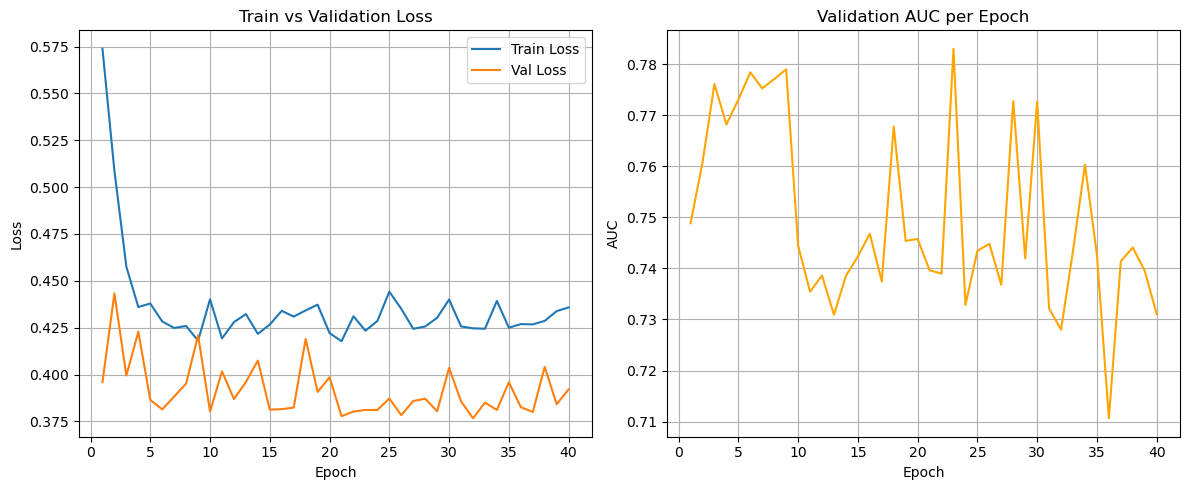

In [286]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_aucs, label="Val AUC", color='orange')
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.title("Validation AUC per Epoch")
plt.grid(True)

plt.tight_layout()
plt.show()


## Computing AUC ROC for all 12 task with 5-fold cross validation and hyperparameter tuning

In [292]:
from sklearn.model_selection import StratifiedKFold

best_results = []

hidden_channels_options = [64, 128, 256]
lr_options = [1e-3, 5e-4, 1e-4]
dropout_locations = ['none', 'after_pool', 'after_fc1']
dropout_rate_options = [0.2, 0.3]
# define the number of epochs
num_epochs = 6


In [293]:
for target in targets:
    print(f"\nProcessing target: {target}")

    # Drop NA values
    y = df[target]
    mask = y.notna()
    x_clean = df['smiles'][mask].to_list()
    y_clean = y[mask].astype(int).to_list()

    full_dataset = create_pytorch_geometric_graph_data_list_from_smiles_and_labels(x_clean, y_clean)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    best_auc = -1
    best_config = {}

    for hidden in hidden_channels_options:
        for lr in lr_options:
            for drop_loc in dropout_locations:

                current_dropout_rates = [0.0] if drop_loc == 'none' else dropout_rate_options
                for drop_rate in current_dropout_rates:

                    auc_scores = []

                    for fold_idx, (train_idx, test_idx) in enumerate(skf.split(x_clean, y_clean)):
                        train_dataset = [full_dataset[i] for i in train_idx]
                        test_dataset = [full_dataset[i] for i in test_idx]

                        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
                        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

                        model = GCN(
                            num_node_features=79,
                            hidden_channels=hidden,
                            dropout_rate=drop_rate,
                            dropout_location=drop_loc
                        ).to(device)

                        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

                        # Training
                        for epoch in range(num_epochs):
                            model.train()
                            for data in train_loader:
                                data = data.to(device)
                                optimizer.zero_grad()
                                out = model(data)
                                loss = F.nll_loss(out, data.y.long(), weight=torch.tensor([0.5, 5]).to(device))
                                loss.backward()
                                optimizer.step()

                        # Evaluation
                        model.eval()
                        y_true, y_probs = [], []

                        with torch.no_grad():
                            for data in test_loader:
                                data = data.to(device)
                                out = model(data)
                                prob = torch.softmax(out, dim=1)[:, 1].cpu().numpy()
                                y_true.extend(data.y.view(-1).cpu().numpy())
                                y_probs.extend(prob)

                        fold_auc = roc_auc_score(y_true, y_probs)
                        auc_scores.append(fold_auc)

                    avg_auc = np.mean(auc_scores)
                    std_auc = np.std(auc_scores)

                    if avg_auc > best_auc:
                        best_auc = avg_auc
                        best_config = {
                            "target": target,
                            "hidden_channels": hidden,
                            "lr": lr,
                            "dropout_location": drop_loc,
                            "dropout_rate": drop_rate,
                            "avg_auc": avg_auc,
                            "std_auc": std_auc
                        }

                    print(f"Target: {target}, Hidden: {hidden}, LR: {lr}, Dropout: {drop_loc}, Rate: {drop_rate} => Avg AUC: {avg_auc:.4f}, Std AUC: {std_auc:.4f}")

    best_results.append(best_config)
    print(f" Best for {target}: AUC={best_auc:.4f} | Config={best_config}")


Processing target: NR-AR


[00:45:35] WARNING: not removing hydrogen atom without neighbors


Target: NR-AR, Hidden: 64, LR: 0.001, Dropout: none, Rate: 0.0 => Avg AUC: 0.8081, Std AUC: 0.0375
Target: NR-AR, Hidden: 64, LR: 0.001, Dropout: after_pool, Rate: 0.2 => Avg AUC: 0.8083, Std AUC: 0.0464
Target: NR-AR, Hidden: 64, LR: 0.001, Dropout: after_pool, Rate: 0.3 => Avg AUC: 0.8038, Std AUC: 0.0411
Target: NR-AR, Hidden: 64, LR: 0.001, Dropout: after_fc1, Rate: 0.2 => Avg AUC: 0.8054, Std AUC: 0.0403
Target: NR-AR, Hidden: 64, LR: 0.001, Dropout: after_fc1, Rate: 0.3 => Avg AUC: 0.8071, Std AUC: 0.0434
Target: NR-AR, Hidden: 64, LR: 0.0005, Dropout: none, Rate: 0.0 => Avg AUC: 0.8050, Std AUC: 0.0451
Target: NR-AR, Hidden: 64, LR: 0.0005, Dropout: after_pool, Rate: 0.2 => Avg AUC: 0.8042, Std AUC: 0.0462
Target: NR-AR, Hidden: 64, LR: 0.0005, Dropout: after_pool, Rate: 0.3 => Avg AUC: 0.8032, Std AUC: 0.0426
Target: NR-AR, Hidden: 64, LR: 0.0005, Dropout: after_fc1, Rate: 0.2 => Avg AUC: 0.8062, Std AUC: 0.0409
Target: NR-AR, Hidden: 64, LR: 0.0005, Dropout: after_fc1, Rate: 0

[01:11:13] WARNING: not removing hydrogen atom without neighbors


Target: NR-AR-LBD, Hidden: 64, LR: 0.001, Dropout: none, Rate: 0.0 => Avg AUC: 0.8318, Std AUC: 0.0327
Target: NR-AR-LBD, Hidden: 64, LR: 0.001, Dropout: after_pool, Rate: 0.2 => Avg AUC: 0.8291, Std AUC: 0.0358
Target: NR-AR-LBD, Hidden: 64, LR: 0.001, Dropout: after_pool, Rate: 0.3 => Avg AUC: 0.8320, Std AUC: 0.0306
Target: NR-AR-LBD, Hidden: 64, LR: 0.001, Dropout: after_fc1, Rate: 0.2 => Avg AUC: 0.8299, Std AUC: 0.0318
Target: NR-AR-LBD, Hidden: 64, LR: 0.001, Dropout: after_fc1, Rate: 0.3 => Avg AUC: 0.8325, Std AUC: 0.0361
Target: NR-AR-LBD, Hidden: 64, LR: 0.0005, Dropout: none, Rate: 0.0 => Avg AUC: 0.8217, Std AUC: 0.0330
Target: NR-AR-LBD, Hidden: 64, LR: 0.0005, Dropout: after_pool, Rate: 0.2 => Avg AUC: 0.8277, Std AUC: 0.0317
Target: NR-AR-LBD, Hidden: 64, LR: 0.0005, Dropout: after_pool, Rate: 0.3 => Avg AUC: 0.8214, Std AUC: 0.0258
Target: NR-AR-LBD, Hidden: 64, LR: 0.0005, Dropout: after_fc1, Rate: 0.2 => Avg AUC: 0.8215, Std AUC: 0.0212
Target: NR-AR-LBD, Hidden: 64,

[01:33:29] WARNING: not removing hydrogen atom without neighbors


Target: NR-AhR, Hidden: 64, LR: 0.001, Dropout: none, Rate: 0.0 => Avg AUC: 0.8483, Std AUC: 0.0164
Target: NR-AhR, Hidden: 64, LR: 0.001, Dropout: after_pool, Rate: 0.2 => Avg AUC: 0.8479, Std AUC: 0.0146
Target: NR-AhR, Hidden: 64, LR: 0.001, Dropout: after_pool, Rate: 0.3 => Avg AUC: 0.8481, Std AUC: 0.0177
Target: NR-AhR, Hidden: 64, LR: 0.001, Dropout: after_fc1, Rate: 0.2 => Avg AUC: 0.8471, Std AUC: 0.0149
Target: NR-AhR, Hidden: 64, LR: 0.001, Dropout: after_fc1, Rate: 0.3 => Avg AUC: 0.8472, Std AUC: 0.0156
Target: NR-AhR, Hidden: 64, LR: 0.0005, Dropout: none, Rate: 0.0 => Avg AUC: 0.8390, Std AUC: 0.0113
Target: NR-AhR, Hidden: 64, LR: 0.0005, Dropout: after_pool, Rate: 0.2 => Avg AUC: 0.8399, Std AUC: 0.0154
Target: NR-AhR, Hidden: 64, LR: 0.0005, Dropout: after_pool, Rate: 0.3 => Avg AUC: 0.8408, Std AUC: 0.0158
Target: NR-AhR, Hidden: 64, LR: 0.0005, Dropout: after_fc1, Rate: 0.2 => Avg AUC: 0.8398, Std AUC: 0.0171
Target: NR-AhR, Hidden: 64, LR: 0.0005, Dropout: after_fc

[01:54:52] WARNING: not removing hydrogen atom without neighbors


Target: NR-Aromatase, Hidden: 64, LR: 0.001, Dropout: none, Rate: 0.0 => Avg AUC: 0.7213, Std AUC: 0.0380
Target: NR-Aromatase, Hidden: 64, LR: 0.001, Dropout: after_pool, Rate: 0.2 => Avg AUC: 0.7279, Std AUC: 0.0375
Target: NR-Aromatase, Hidden: 64, LR: 0.001, Dropout: after_pool, Rate: 0.3 => Avg AUC: 0.7243, Std AUC: 0.0374
Target: NR-Aromatase, Hidden: 64, LR: 0.001, Dropout: after_fc1, Rate: 0.2 => Avg AUC: 0.7237, Std AUC: 0.0319
Target: NR-Aromatase, Hidden: 64, LR: 0.001, Dropout: after_fc1, Rate: 0.3 => Avg AUC: 0.7220, Std AUC: 0.0382
Target: NR-Aromatase, Hidden: 64, LR: 0.0005, Dropout: none, Rate: 0.0 => Avg AUC: 0.7213, Std AUC: 0.0438
Target: NR-Aromatase, Hidden: 64, LR: 0.0005, Dropout: after_pool, Rate: 0.2 => Avg AUC: 0.7134, Std AUC: 0.0439
Target: NR-Aromatase, Hidden: 64, LR: 0.0005, Dropout: after_pool, Rate: 0.3 => Avg AUC: 0.7113, Std AUC: 0.0429
Target: NR-Aromatase, Hidden: 64, LR: 0.0005, Dropout: after_fc1, Rate: 0.2 => Avg AUC: 0.7078, Std AUC: 0.0333
Tar

[02:13:58] WARNING: not removing hydrogen atom without neighbors


Target: NR-ER, Hidden: 64, LR: 0.001, Dropout: none, Rate: 0.0 => Avg AUC: 0.7020, Std AUC: 0.0176
Target: NR-ER, Hidden: 64, LR: 0.001, Dropout: after_pool, Rate: 0.2 => Avg AUC: 0.7041, Std AUC: 0.0241
Target: NR-ER, Hidden: 64, LR: 0.001, Dropout: after_pool, Rate: 0.3 => Avg AUC: 0.7002, Std AUC: 0.0206
Target: NR-ER, Hidden: 64, LR: 0.001, Dropout: after_fc1, Rate: 0.2 => Avg AUC: 0.7049, Std AUC: 0.0176
Target: NR-ER, Hidden: 64, LR: 0.001, Dropout: after_fc1, Rate: 0.3 => Avg AUC: 0.6991, Std AUC: 0.0198
Target: NR-ER, Hidden: 64, LR: 0.0005, Dropout: none, Rate: 0.0 => Avg AUC: 0.7009, Std AUC: 0.0203
Target: NR-ER, Hidden: 64, LR: 0.0005, Dropout: after_pool, Rate: 0.2 => Avg AUC: 0.6992, Std AUC: 0.0219
Target: NR-ER, Hidden: 64, LR: 0.0005, Dropout: after_pool, Rate: 0.3 => Avg AUC: 0.6992, Std AUC: 0.0218
Target: NR-ER, Hidden: 64, LR: 0.0005, Dropout: after_fc1, Rate: 0.2 => Avg AUC: 0.7001, Std AUC: 0.0188
Target: NR-ER, Hidden: 64, LR: 0.0005, Dropout: after_fc1, Rate: 0

[02:34:47] WARNING: not removing hydrogen atom without neighbors


Target: NR-ER-LBD, Hidden: 64, LR: 0.001, Dropout: none, Rate: 0.0 => Avg AUC: 0.7538, Std AUC: 0.0304
Target: NR-ER-LBD, Hidden: 64, LR: 0.001, Dropout: after_pool, Rate: 0.2 => Avg AUC: 0.7530, Std AUC: 0.0279
Target: NR-ER-LBD, Hidden: 64, LR: 0.001, Dropout: after_pool, Rate: 0.3 => Avg AUC: 0.7469, Std AUC: 0.0299
Target: NR-ER-LBD, Hidden: 64, LR: 0.001, Dropout: after_fc1, Rate: 0.2 => Avg AUC: 0.7532, Std AUC: 0.0305
Target: NR-ER-LBD, Hidden: 64, LR: 0.001, Dropout: after_fc1, Rate: 0.3 => Avg AUC: 0.7463, Std AUC: 0.0342
Target: NR-ER-LBD, Hidden: 64, LR: 0.0005, Dropout: none, Rate: 0.0 => Avg AUC: 0.7434, Std AUC: 0.0353
Target: NR-ER-LBD, Hidden: 64, LR: 0.0005, Dropout: after_pool, Rate: 0.2 => Avg AUC: 0.7394, Std AUC: 0.0290
Target: NR-ER-LBD, Hidden: 64, LR: 0.0005, Dropout: after_pool, Rate: 0.3 => Avg AUC: 0.7472, Std AUC: 0.0286
Target: NR-ER-LBD, Hidden: 64, LR: 0.0005, Dropout: after_fc1, Rate: 0.2 => Avg AUC: 0.7394, Std AUC: 0.0360
Target: NR-ER-LBD, Hidden: 64,

[02:58:35] WARNING: not removing hydrogen atom without neighbors


Target: NR-PPAR-gamma, Hidden: 64, LR: 0.001, Dropout: none, Rate: 0.0 => Avg AUC: 0.7285, Std AUC: 0.0173
Target: NR-PPAR-gamma, Hidden: 64, LR: 0.001, Dropout: after_pool, Rate: 0.2 => Avg AUC: 0.7148, Std AUC: 0.0334
Target: NR-PPAR-gamma, Hidden: 64, LR: 0.001, Dropout: after_pool, Rate: 0.3 => Avg AUC: 0.7135, Std AUC: 0.0334
Target: NR-PPAR-gamma, Hidden: 64, LR: 0.001, Dropout: after_fc1, Rate: 0.2 => Avg AUC: 0.7202, Std AUC: 0.0251
Target: NR-PPAR-gamma, Hidden: 64, LR: 0.001, Dropout: after_fc1, Rate: 0.3 => Avg AUC: 0.7201, Std AUC: 0.0328
Target: NR-PPAR-gamma, Hidden: 64, LR: 0.0005, Dropout: none, Rate: 0.0 => Avg AUC: 0.7082, Std AUC: 0.0195
Target: NR-PPAR-gamma, Hidden: 64, LR: 0.0005, Dropout: after_pool, Rate: 0.2 => Avg AUC: 0.7031, Std AUC: 0.0252
Target: NR-PPAR-gamma, Hidden: 64, LR: 0.0005, Dropout: after_pool, Rate: 0.3 => Avg AUC: 0.6970, Std AUC: 0.0367
Target: NR-PPAR-gamma, Hidden: 64, LR: 0.0005, Dropout: after_fc1, Rate: 0.2 => Avg AUC: 0.6949, Std AUC: 0

[03:37:41] WARNING: not removing hydrogen atom without neighbors


Target: SR-ATAD5, Hidden: 64, LR: 0.001, Dropout: none, Rate: 0.0 => Avg AUC: 0.7444, Std AUC: 0.0279
Target: SR-ATAD5, Hidden: 64, LR: 0.001, Dropout: after_pool, Rate: 0.2 => Avg AUC: 0.7391, Std AUC: 0.0290
Target: SR-ATAD5, Hidden: 64, LR: 0.001, Dropout: after_pool, Rate: 0.3 => Avg AUC: 0.7411, Std AUC: 0.0261
Target: SR-ATAD5, Hidden: 64, LR: 0.001, Dropout: after_fc1, Rate: 0.2 => Avg AUC: 0.7436, Std AUC: 0.0158
Target: SR-ATAD5, Hidden: 64, LR: 0.001, Dropout: after_fc1, Rate: 0.3 => Avg AUC: 0.7436, Std AUC: 0.0268
Target: SR-ATAD5, Hidden: 64, LR: 0.0005, Dropout: none, Rate: 0.0 => Avg AUC: 0.7386, Std AUC: 0.0197
Target: SR-ATAD5, Hidden: 64, LR: 0.0005, Dropout: after_pool, Rate: 0.2 => Avg AUC: 0.7415, Std AUC: 0.0241
Target: SR-ATAD5, Hidden: 64, LR: 0.0005, Dropout: after_pool, Rate: 0.3 => Avg AUC: 0.7363, Std AUC: 0.0238
Target: SR-ATAD5, Hidden: 64, LR: 0.0005, Dropout: after_fc1, Rate: 0.2 => Avg AUC: 0.7307, Std AUC: 0.0251
Target: SR-ATAD5, Hidden: 64, LR: 0.000

[04:00:34] WARNING: not removing hydrogen atom without neighbors


Target: SR-HSE, Hidden: 64, LR: 0.001, Dropout: none, Rate: 0.0 => Avg AUC: 0.7439, Std AUC: 0.0202
Target: SR-HSE, Hidden: 64, LR: 0.001, Dropout: after_pool, Rate: 0.2 => Avg AUC: 0.7412, Std AUC: 0.0282
Target: SR-HSE, Hidden: 64, LR: 0.001, Dropout: after_pool, Rate: 0.3 => Avg AUC: 0.7367, Std AUC: 0.0190
Target: SR-HSE, Hidden: 64, LR: 0.001, Dropout: after_fc1, Rate: 0.2 => Avg AUC: 0.7380, Std AUC: 0.0255
Target: SR-HSE, Hidden: 64, LR: 0.001, Dropout: after_fc1, Rate: 0.3 => Avg AUC: 0.7344, Std AUC: 0.0188
Target: SR-HSE, Hidden: 64, LR: 0.0005, Dropout: none, Rate: 0.0 => Avg AUC: 0.7197, Std AUC: 0.0262
Target: SR-HSE, Hidden: 64, LR: 0.0005, Dropout: after_pool, Rate: 0.2 => Avg AUC: 0.7147, Std AUC: 0.0123
Target: SR-HSE, Hidden: 64, LR: 0.0005, Dropout: after_pool, Rate: 0.3 => Avg AUC: 0.7086, Std AUC: 0.0287
Target: SR-HSE, Hidden: 64, LR: 0.0005, Dropout: after_fc1, Rate: 0.2 => Avg AUC: 0.7161, Std AUC: 0.0280
Target: SR-HSE, Hidden: 64, LR: 0.0005, Dropout: after_fc

[04:21:03] WARNING: not removing hydrogen atom without neighbors


Target: SR-MMP, Hidden: 64, LR: 0.001, Dropout: none, Rate: 0.0 => Avg AUC: 0.8216, Std AUC: 0.0138
Target: SR-MMP, Hidden: 64, LR: 0.001, Dropout: after_pool, Rate: 0.2 => Avg AUC: 0.8204, Std AUC: 0.0132
Target: SR-MMP, Hidden: 64, LR: 0.001, Dropout: after_pool, Rate: 0.3 => Avg AUC: 0.8248, Std AUC: 0.0092
Target: SR-MMP, Hidden: 64, LR: 0.001, Dropout: after_fc1, Rate: 0.2 => Avg AUC: 0.8265, Std AUC: 0.0107
Target: SR-MMP, Hidden: 64, LR: 0.001, Dropout: after_fc1, Rate: 0.3 => Avg AUC: 0.8219, Std AUC: 0.0111
Target: SR-MMP, Hidden: 64, LR: 0.0005, Dropout: none, Rate: 0.0 => Avg AUC: 0.8139, Std AUC: 0.0144
Target: SR-MMP, Hidden: 64, LR: 0.0005, Dropout: after_pool, Rate: 0.2 => Avg AUC: 0.8053, Std AUC: 0.0150
Target: SR-MMP, Hidden: 64, LR: 0.0005, Dropout: after_pool, Rate: 0.3 => Avg AUC: 0.8070, Std AUC: 0.0125
Target: SR-MMP, Hidden: 64, LR: 0.0005, Dropout: after_fc1, Rate: 0.2 => Avg AUC: 0.8105, Std AUC: 0.0102
Target: SR-MMP, Hidden: 64, LR: 0.0005, Dropout: after_fc

[04:40:46] WARNING: not removing hydrogen atom without neighbors


Target: SR-p53, Hidden: 64, LR: 0.001, Dropout: none, Rate: 0.0 => Avg AUC: 0.7701, Std AUC: 0.0118
Target: SR-p53, Hidden: 64, LR: 0.001, Dropout: after_pool, Rate: 0.2 => Avg AUC: 0.7674, Std AUC: 0.0084
Target: SR-p53, Hidden: 64, LR: 0.001, Dropout: after_pool, Rate: 0.3 => Avg AUC: 0.7682, Std AUC: 0.0086
Target: SR-p53, Hidden: 64, LR: 0.001, Dropout: after_fc1, Rate: 0.2 => Avg AUC: 0.7650, Std AUC: 0.0119
Target: SR-p53, Hidden: 64, LR: 0.001, Dropout: after_fc1, Rate: 0.3 => Avg AUC: 0.7637, Std AUC: 0.0059
Target: SR-p53, Hidden: 64, LR: 0.0005, Dropout: none, Rate: 0.0 => Avg AUC: 0.7625, Std AUC: 0.0147
Target: SR-p53, Hidden: 64, LR: 0.0005, Dropout: after_pool, Rate: 0.2 => Avg AUC: 0.7564, Std AUC: 0.0089
Target: SR-p53, Hidden: 64, LR: 0.0005, Dropout: after_pool, Rate: 0.3 => Avg AUC: 0.7517, Std AUC: 0.0092
Target: SR-p53, Hidden: 64, LR: 0.0005, Dropout: after_fc1, Rate: 0.2 => Avg AUC: 0.7541, Std AUC: 0.0097
Target: SR-p53, Hidden: 64, LR: 0.0005, Dropout: after_fc

In [445]:
# Output the dataframe
best_df = pd.DataFrame(best_results)
best_df.to_csv('best_results.csv', index=False)


In [446]:
best_df

,target,hidden_channels,lr,dropout_location,dropout_rate,avg_auc,std_auc
0,NR-AR,256,0.0005,none,0.0,0.811782,0.043223
1,NR-AR-LBD,256,0.0010,after_fc1,0.2,0.840040,0.036091
2,NR-AhR,256,0.0010,after_pool,0.2,0.865069,0.016027
3,NR-Aromatase,256,0.0010,after_pool,0.2,0.746495,0.033370
4,NR-ER,256,0.0005,after_pool,0.2,0.710840,0.018788
5,NR-ER-LBD,128,0.0010,none,0.0,0.765347,0.029426
6,NR-PPAR-gamma,256,0.0010,after_pool,0.2,0.761829,0.023749
7,SR-ARE,256,0.0010,after_fc1,0.2,0.750254,0.026339
8,SR-ATAD5,128,0.0010,none,0.0,0.769249,0.023672
9,SR-HSE,256,0.0010,none,0.0,0.762118,0.022788


## Multi-class classification

In [359]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class GCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, dropout_rate=0.3,
                 dropout_location='none', out_channels=12):  # 12 for Tox21 tasks
        super().__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)

        self.fc1 = torch.nn.Linear(hidden_channels, hidden_channels // 2)
        self.fc2 = torch.nn.Linear(hidden_channels // 2, out_channels)

        self.dropout_rate = dropout_rate
        self.dropout_location = dropout_location.lower()

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))

        x = global_mean_pool(x, batch)

        if self.dropout_location in ['after_pool', 'both']:
            x = F.dropout(x, p=self.dropout_rate, training=self.training)

        x = F.relu(self.fc1(x))

        if self.dropout_location in ['after_fc1', 'both']:
            x = F.dropout(x, p=self.dropout_rate, training=self.training)

        x = self.fc2(x)  # Raw logits for each task

        return x  # No activation here


In [ ]:
# have to change definition a bit to store multiple labels

from torch_geometric.data import Data
import torch
import numpy as np
from rdkit import Chem
from rdkit.Chem.rdmolops import GetAdjacencyMatrix

def create_pytorch_geometric_graph_data_list_from_smiles_and_labels(x_smiles, y_multi):
    """
    x_smiles: List[str]
        SMILES strings.
    y_multi: List[List[float]]
        Multi-task labels per SMILES (e.g., 12 values for Tox21, with NaNs for missing).
    """
    data_list = []

    for smiles, y_vector in zip(x_smiles, y_multi):
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            continue  # Skip invalid SMILES

        n_nodes = mol.GetNumAtoms()
        n_edges = 2 * mol.GetNumBonds()

        # Use a dummy mol to get feature dimensions
        dummy_mol = Chem.MolFromSmiles("O=O")
        n_node_features = len(get_atom_features(dummy_mol.GetAtomWithIdx(0)))
        n_edge_features = len(get_bond_features(dummy_mol.GetBondBetweenAtoms(0, 1)))

        # Node features
        X = np.zeros((n_nodes, n_node_features))
        for atom in mol.GetAtoms():
            X[atom.GetIdx()] = get_atom_features(atom)
        X = torch.tensor(X, dtype=torch.float)

        # Edge index
        rows, cols = np.nonzero(GetAdjacencyMatrix(mol))
        E = torch.tensor([rows, cols], dtype=torch.long)

        # Edge features
        EF = np.zeros((len(rows), n_edge_features))
        for idx, (i, j) in enumerate(zip(rows, cols)):
            bond = mol.GetBondBetweenAtoms(int(i), int(j))
            if bond is not None:
                EF[idx] = get_bond_features(bond)
        EF = torch.tensor(EF, dtype=torch.float)

        # Multi-task labels
        # y_tensor = torch.tensor(y_vector, dtype=torch.float)  # can include NaNs
        y_tensor = torch.tensor(y_vector, dtype=torch.float).unsqueeze(0)  # shape [1, 12]


        data = Data(x=X, edge_index=E, edge_attr=EF, y=y_tensor)
        data_list.append(data)

    return data_list


In [373]:
x_clean = df['smiles'].tolist()
y_clean = df[targets].values.tolist() 
full_dataset = create_pytorch_geometric_graph_data_list_from_smiles_and_labels(x_clean, y_clean)
full_dataset[0].y.shape

[23:16:51] WARNING: not removing hydrogen atom without neighbors


torch.Size([1, 12])

In [ ]:
def multitask_loss(output, target):
    # Ensure target and output are [B, 12], mask out NaNs
    mask = ~torch.isnan(target)
    target_clean = torch.masked_select(target, mask)
    output_clean = torch.masked_select(output, mask)

    if target_clean.numel() == 0:
        print("⚠️ Skipping batch with all NaNs")
        return torch.tensor(0.0, requires_grad=True).to(output.device)

    return F.binary_cross_entropy_with_logits(output_clean, target_clean, reduction='mean')

In [ ]:
def evaluate(model, dataloader):
    model.eval()
    y_true_all = [[] for _ in range(nuåm_tasks)]
    y_pred_all = [[] for _ in range(num_tasks)]

    with torch.no_grad():
        for data in dataloader:
            data = data.to(device)
            out = model(data)
            probs = torch.sigmoid(out).cpu().numpy()
            true = data.y.cpu().numpy()

            for i in range(num_tasks):
                mask = ~np.isnan(true[:, i])
                y_true_all[i].extend(true[mask, i])
                y_pred_all[i].extend(probs[mask, i])

    aucs = []
    for i in range(num_tasks):
        labels = y_true_all[i]
        preds = y_pred_all[i]
        if len(set(labels)) > 1:
            try:
                auc = roc_auc_score(labels, preds)
            except Exception as e:
                print(f"⚠️ AUC error on task {targets[i]}:", e)
                auc = np.nan
        else:
            print(f"⚠️ Skipping AUC for {targets[i]}: only one class present.")
            auc = np.nan
        aucs.append(auc)
    return aucs

In [385]:
from sklearn.model_selection import KFold

hidden_channels_options = [64, 128, 256]
lr_options = [1e-3, 5e-4, 1e-4]
dropout_locations = ['none', 'after_pool', 'after_fc1']
dropout_rate_options = [0.2, 0.3]
# define the number of epochs
num_epochs = 60
k_folds = 5
batch_size = 32

# Grid search
best_auc_macro = -1
best_config = {}
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

In [386]:
for hidden in hidden_channels_options:
    for lr in lr_options:
        for drop_loc in dropout_locations:
            current_dropout_rates = [0.0] if drop_loc == 'none' else dropout_rate_options
            for drop_rate in current_dropout_rates:

                print(f"\n🧪 Testing config: Hidden={hidden}, LR={lr}, Dropout={drop_loc}, Rate={drop_rate}")
                all_fold_aucs = []

                for fold_idx, (train_idx, test_idx) in enumerate(kf.split(full_dataset)):
                    print(f"  Fold {fold_idx + 1}/{k_folds}")

                    train_dataset = [full_dataset[i] for i in train_idx]
                    test_dataset = [full_dataset[i] for i in test_idx]
                    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

                    model = GCN(
                        num_node_features=79,
                        hidden_channels=hidden,
                        dropout_rate=drop_rate,
                        dropout_location=drop_loc,
                        out_channels=num_tasks
                    ).to(device)

                    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

                    # Training
                    for epoch in range(num_epochs):
                        model.train()
                        for data in train_loader:
                            data = data.to(device)
                            optimizer.zero_grad()
                            out = model(data)
                            loss = multitask_loss(out, data.y)
                            loss.backward()
                            optimizer.step()

                    # Evaluation
                    aucs = evaluate(model, test_loader)
                    all_fold_aucs.append(aucs)
                    print(f"    AUCs: {[round(a, 4) if not np.isnan(a) else 'nan' for a in aucs]}")

                # Aggregate over folds
                all_fold_aucs = np.array(all_fold_aucs)
                mean_aucs = np.nanmean(all_fold_aucs, axis=0)
                macro_avg_auc = np.nanmean(mean_aucs)
                print({
                        "hidden_channels": hidden,
                        "lr": lr,
                        "dropout_location": drop_loc,
                        "dropout_rate": drop_rate,
                        "auc_per_target": dict(zip(targets, mean_aucs)),
                        "macro_avg_auc": macro_avg_auc
                    })

                print(f"📊 Macro Avg AUC: {macro_avg_auc:.4f}")

                if macro_avg_auc > best_auc_macro:
                    best_auc_macro = macro_avg_auc
                    best_config = {
                        "hidden_channels": hidden,
                        "lr": lr,
                        "dropout_location": drop_loc,
                        "dropout_rate": drop_rate,
                        "auc_per_target": dict(zip(targets, mean_aucs)),
                        "macro_avg_auc": macro_avg_auc
                    }


🧪 Testing config: Hidden=64, LR=0.001, Dropout=none, Rate=0.0
  Fold 1/5
    AUCs: [np.float64(0.801), np.float64(0.8811), np.float64(0.8956), np.float64(0.8241), np.float64(0.728), np.float64(0.8191), np.float64(0.803), np.float64(0.7982), np.float64(0.8144), np.float64(0.8387), np.float64(0.882), np.float64(0.8321)]
  Fold 2/5
    AUCs: [np.float64(0.7893), np.float64(0.847), np.float64(0.8775), np.float64(0.8475), np.float64(0.6987), np.float64(0.844), np.float64(0.8128), np.float64(0.8139), np.float64(0.8275), np.float64(0.8114), np.float64(0.8702), np.float64(0.8196)]
  Fold 3/5
    AUCs: [np.float64(0.8461), np.float64(0.877), np.float64(0.879), np.float64(0.8703), np.float64(0.7309), np.float64(0.8338), np.float64(0.8656), np.float64(0.7957), np.float64(0.8985), np.float64(0.8117), np.float64(0.8847), np.float64(0.8561)]
  Fold 4/5
    AUCs: [np.float64(0.817), np.float64(0.9334), np.float64(0.8834), np.float64(0.8202), np.float64(0.738), np.float64(0.8607), np.float64(0.8819),

In [387]:
# Final result
print("\n✅ BEST CONFIGURATION FOUND:")
for k, v in best_config.items():
    if isinstance(v, dict):
        print(f"{k}:")
        for subk, subv in v.items():
            print(f"  {subk}: {subv:.4f}")
    else:
        print(f"{k}: {v}")


✅ BEST CONFIGURATION FOUND:
hidden_channels: 256
lr: 0.001
dropout_location: after_pool
dropout_rate: 0.2
auc_per_target:
  NR-AR: 0.7986
  NR-AR-LBD: 0.8692
  NR-AhR: 0.8937
  NR-Aromatase: 0.8584
  NR-ER: 0.7270
  NR-ER-LBD: 0.8366
  NR-PPAR-gamma: 0.8753
  SR-ARE: 0.8302
  SR-ATAD5: 0.8707
  SR-HSE: 0.8141
  SR-MMP: 0.9055
  SR-p53: 0.8729
macro_avg_auc: 0.8460160489436519


In [432]:
# std for best calculation 
all_auc_lst = [[np.float64(0.7938), np.float64(0.8742), np.float64(0.9093), np.float64(0.8634), np.float64(0.7115), np.float64(0.8081), np.float64(0.8078), np.float64(0.8368), np.float64(0.8315), np.float64(0.8013), np.float64(0.909), np.float64(0.8385)],
[np.float64(0.7873), np.float64(0.818), np.float64(0.8901), np.float64(0.8598), np.float64(0.7189), np.float64(0.8402), np.float64(0.8842), np.float64(0.8173), np.float64(0.8411), np.float64(0.8091), np.float64(0.9017), np.float64(0.8452)],
[np.float64(0.8173), np.float64(0.855), np.float64(0.8802), np.float64(0.8762), np.float64(0.7332), np.float64(0.8516), np.float64(0.9018), np.float64(0.8239), np.float64(0.8964), np.float64(0.8289), np.float64(0.9074), np.float64(0.877)],
[np.float64(0.8137), np.float64(0.9407), np.float64(0.9), np.float64(0.8312), np.float64(0.7662), np.float64(0.8707), np.float64(0.8935), np.float64(0.8407), np.float64(0.9288), np.float64(0.835), np.float64(0.8945), np.float64(0.8817)],
[np.float64(0.7809), np.float64(0.8581), np.float64(0.8889), np.float64(0.8615), np.float64(0.7052), np.float64(0.8125), np.float64(0.8893), np.float64(0.8324), np.float64(0.8554), np.float64(0.7963), np.float64(0.9147), np.float64(0.9221)]]

In [439]:
dic_GCN_std = {}
for i in range(12):
    print(np.std([all_auc_lst[0][i], all_auc_lst[1][i], all_auc_lst[2][i], all_auc_lst[3][i], all_auc_lst[4][i]]))
    dic_GCN_std[targets[i]] = np.std([all_auc_lst[0][i], all_auc_lst[1][i], all_auc_lst[2][i], all_auc_lst[3][i], all_auc_lst[4][i]])

dic_GCN_std


0.01443412622918339
0.04020830759930093
0.010012991560967186
0.014786804928719364
0.021707970886289656
0.023638223283487275
0.03424893574988865
0.008541053799151481
0.03655946389103646
0.015241574721793
0.006869235765352658
0.029884912581434817


{'NR-AR': np.float64(0.01443412622918339),
 'NR-AR-LBD': np.float64(0.04020830759930093),
 'NR-AhR': np.float64(0.010012991560967186),
 'NR-Aromatase': np.float64(0.014786804928719364),
 'NR-ER': np.float64(0.021707970886289656),
 'NR-ER-LBD': np.float64(0.023638223283487275),
 'NR-PPAR-gamma': np.float64(0.03424893574988865),
 'SR-ARE': np.float64(0.008541053799151481),
 'SR-ATAD5': np.float64(0.03655946389103646),
 'SR-HSE': np.float64(0.015241574721793),
 'SR-MMP': np.float64(0.006869235765352658),
 'SR-p53': np.float64(0.029884912581434817)}

In [389]:
df_multi_class_best = pd.DataFrame(best_config['auc_per_target'].items(), columns=['Target', 'AUC'])
df_multi_class_best.to_csv('best_auc_per_target_multi_class.csv', index=False)

In [ ]:
# test run with high epoch number and no hyperparameter tuning just to find best epoch number

# train_loss_list = []
# # val_loss = []
# macro_auc_list = []
# best_macro_auc = -1


# # ✅ Sanity check: 1 sample
# print("📦 First molecule label vector:", full_dataset[0].y.shape)  # should be [12]

# # === DATA SPLIT ===
# train_data, test_data = train_test_split(full_dataset, test_size=0.2, random_state=42)
# train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
# test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# # === MODEL ===
# model = GCN(
#     num_node_features=79,
#     hidden_channels=128,
#     dropout_rate=0.3,
#     dropout_location='after_fc1',
#     out_channels=num_tasks
# ).to(device)

# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# # === EVALUATION FUNCTION ===
# def evaluate(model, dataloader):
#     model.eval()
#     y_true_all = [[] for _ in range(num_tasks)]
#     y_pred_all = [[] for _ in range(num_tasks)]

#     with torch.no_grad():
#         for data in dataloader:
#             data = data.to(device)
#             out = model(data)
#             probs = torch.sigmoid(out).cpu().numpy()
#             true = data.y.cpu().numpy()

#             for i in range(num_tasks):
#                 mask = ~np.isnan(true[:, i])
#                 y_true_all[i].extend(true[mask, i])
#                 y_pred_all[i].extend(probs[mask, i])

#     aucs = []
#     for i in range(num_tasks):
#         labels = y_true_all[i]
#         preds = y_pred_all[i]
#         if len(set(labels)) > 1:
#             try:
#                 auc = roc_auc_score(labels, preds)
#             except Exception as e:
#                 print(f" AUC error on task {targets[i]}:", e)
#                 auc = np.nan
#         else:
#             print(f" Skipping AUC for {targets[i]}: only one class present.")
#             auc = np.nan
#         aucs.append(auc)
#     return aucs

# # === TRAIN LOOP ===
# for epoch in range(1, 100):
#     model.train()
#     total_loss = 0
#     for batch_idx, data in enumerate(train_loader):
#         data = data.to(device)

#         # Check y shape and consistency
#         if data.y.dim() != 2 or data.y.shape[1] != num_tasks:
#             print(f"❌ Invalid shape: {data.y.shape}")
#             continue

#         optimizer.zero_grad()
#         out = model(data)

#         if torch.isnan(out).any():
#             print(f"❌ NaN in model output at epoch {epoch}, batch {batch_idx}")
#             continue

#         loss = multitask_loss(out, data.y)
#         if torch.isnan(loss):
#             print(f"❌ NaN loss at epoch {epoch}, batch {batch_idx}")
#             continue

#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()
#         train_loss_list.append(total_loss)
#     print(f"✅ Epoch {epoch} complete | Loss: {total_loss:.4f}")

#     val_aucs = evaluate(model, test_loader)
#     macro_auc = np.nanmean(val_aucs)
#     print(f"📈 Validation Macro AUC: {macro_auc:.4f}")
#     for name, auc in zip(targets, val_aucs):
#         print(f"   {name}: {auc:.4f}" if not np.isnan(auc) else f"   {name}: nan")
#     macro_auc_list.append(macro_auc)
#     if macro_auc > best_macro_auc:
#         best_macro_auc = macro_auc
#         best_epoch = epoch
#         best_aucs = val_aucs.copy()
#         print(f"🚀 New best model found at epoch {epoch} with macro AUC: {macro_auc:.4f}")
# # # === FINAL EVAL ===
# # aucs = evaluate(model, test_loader)
# # print("\n📊 Final AUCs:")
# # for name, auc in zip(targets, aucs):
# #     print(f"{name}: {auc:.4f}" if not np.isnan(auc) else f"{name}: nan")


📦 First molecule label vector: torch.Size([1, 12])
✅ Epoch 1 complete | Loss: 58.7913
📈 Validation Macro AUC: 0.6940
   NR-AR: 0.7515
   NR-AR-LBD: 0.7405
   NR-AhR: 0.7687
   NR-Aromatase: 0.6804
   NR-ER: 0.6720
   NR-ER-LBD: 0.6956
   NR-PPAR-gamma: 0.6471
   SR-ARE: 0.6585
   SR-ATAD5: 0.6328
   SR-HSE: 0.6364
   SR-MMP: 0.7290
   SR-p53: 0.7155
🚀 New best model found at epoch 1 with macro AUC: 0.6940
✅ Epoch 2 complete | Loss: 49.4226
📈 Validation Macro AUC: 0.7159
   NR-AR: 0.7926
   NR-AR-LBD: 0.7780
   NR-AhR: 0.7713
   NR-Aromatase: 0.7159
   NR-ER: 0.6879
   NR-ER-LBD: 0.7275
   NR-PPAR-gamma: 0.6716
   SR-ARE: 0.6765
   SR-ATAD5: 0.6354
   SR-HSE: 0.6636
   SR-MMP: 0.7430
   SR-p53: 0.7271
🚀 New best model found at epoch 2 with macro AUC: 0.7159
✅ Epoch 3 complete | Loss: 47.7487
📈 Validation Macro AUC: 0.7212
   NR-AR: 0.7786
   NR-AR-LBD: 0.7728
   NR-AhR: 0.8027
   NR-Aromatase: 0.7214
   NR-ER: 0.6948
   NR-ER-LBD: 0.7347
   NR-PPAR-gamma: 0.6764
   SR-ARE: 0.6783
   SR-

In [ ]:
# found out 60 epoch best for multi target

## Using MPNN

In [ ]:
hidden_channels_options = [64, 128, 256]
lr_options = [1e-3, 5e-4, 1e-4]
dropout_locations = ['none', 'after_pool', 'after_fc1']
dropout_rate_options = [0.2, 0.3]

In [428]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import NNConv, global_mean_pool
from torch_geometric.loader import DataLoader
import torch.nn as nn

class MPNN(torch.nn.Module):
    def __init__(self, num_node_features, edge_features, hidden_channels=64,
                 dropout_rate=0.2, dropout_location='none', out_channels=12):
        super().__init__()

        self.edge_mlp = nn.Linear(edge_features, num_node_features * hidden_channels)

        self.conv1 = NNConv(num_node_features, hidden_channels, self.edge_mlp, aggr='mean')

        self.fc1 = nn.Linear(hidden_channels, hidden_channels // 2)
        self.fc2 = nn.Linear(hidden_channels // 2, out_channels)

        self.dropout_rate = dropout_rate
        self.dropout_location = dropout_location.lower()

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        x = F.relu(self.conv1(x, edge_index, edge_attr))

        x = global_mean_pool(x, batch)

        if self.dropout_location in ['after_pool', 'both']:
            x = F.dropout(x, p=self.dropout_rate, training=self.training)

        x = F.relu(self.fc1(x))

        if self.dropout_location in ['after_fc1', 'both']:
            x = F.dropout(x, p=self.dropout_rate, training=self.training)

        return self.fc2(x)


In [429]:
full_dataset[0].edge_attr.shape[1]

10

In [430]:
for hidden in hidden_channels_options:
    for lr in lr_options:
        for drop_loc in dropout_locations:
            current_dropout_rates = [0.0] if drop_loc == 'none' else dropout_rate_options
            for drop_rate in current_dropout_rates:

                print(f"\n🧪 Testing config: Hidden={hidden}, LR={lr}, Dropout={drop_loc}, Rate={drop_rate}")
                all_fold_aucs = []

                for fold_idx, (train_idx, test_idx) in enumerate(kf.split(full_dataset)):
                    print(f"  Fold {fold_idx + 1}/{k_folds}")

                    train_dataset = [full_dataset[i] for i in train_idx]
                    test_dataset = [full_dataset[i] for i in test_idx]
                    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

                    model = MPNN(
                        num_node_features=79,
                        edge_features=10,
                        hidden_channels=hidden,
                        dropout_rate=drop_rate,
                        dropout_location=drop_loc,
                        out_channels=num_tasks
                    ).to(device)

                    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

                    # Training
                    for epoch in range(num_epochs):
                        model.train()
                        for data in train_loader:
                            data = data.to(device)
                            optimizer.zero_grad()
                            out = model(data)
                            loss = multitask_loss(out, data.y)
                            loss.backward()
                            optimizer.step()

                    # Evaluation
                    aucs = evaluate(model, test_loader)
                    all_fold_aucs.append(aucs)
                    print(f"    AUCs: {[round(a, 4) if not np.isnan(a) else 'nan' for a in aucs]}")

                # Aggregate over folds
                all_fold_aucs = np.array(all_fold_aucs)
                mean_aucs = np.nanmean(all_fold_aucs, axis=0)
                macro_avg_auc = np.nanmean(mean_aucs)
                print({
                        "hidden_channels": hidden,
                        "lr": lr,
                        "dropout_location": drop_loc,
                        "dropout_rate": drop_rate,
                        "auc_per_target": dict(zip(targets, mean_aucs)),
                        "macro_avg_auc": macro_avg_auc
                    })

                print(f"📊 Macro Avg AUC: {macro_avg_auc:.4f}")

                if macro_avg_auc > best_auc_macro:
                    best_auc_macro = macro_avg_auc
                    best_config = {
                        "hidden_channels": hidden,
                        "lr": lr,
                        "dropout_location": drop_loc,
                        "dropout_rate": drop_rate,
                        "auc_per_target": dict(zip(targets, mean_aucs)),
                        "macro_avg_auc": macro_avg_auc
                    }


🧪 Testing config: Hidden=128, LR=0.001, Dropout=none, Rate=0.0
  Fold 1/5
    AUCs: [np.float64(0.8111), np.float64(0.8653), np.float64(0.9144), np.float64(0.8678), np.float64(0.7167), np.float64(0.8196), np.float64(0.8061), np.float64(0.8405), np.float64(0.8132), np.float64(0.8055), np.float64(0.9037), np.float64(0.8314)]
  Fold 2/5
    AUCs: [np.float64(0.8041), np.float64(0.8274), np.float64(0.8959), np.float64(0.8582), np.float64(0.691), np.float64(0.8253), np.float64(0.8469), np.float64(0.81), np.float64(0.8538), np.float64(0.843), np.float64(0.8912), np.float64(0.8265)]
  Fold 3/5
    AUCs: [np.float64(0.8274), np.float64(0.8846), np.float64(0.8911), np.float64(0.8487), np.float64(0.7347), np.float64(0.8389), np.float64(0.8897), np.float64(0.8192), np.float64(0.8998), np.float64(0.8392), np.float64(0.8942), np.float64(0.8719)]
  Fold 4/5
    AUCs: [np.float64(0.7887), np.float64(0.9259), np.float64(0.9088), np.float64(0.8258), np.float64(0.747), np.float64(0.8327), np.float64(0.

In [ ]:
# Final result (for MPNN) I forgot to change best config param so it is not updated there
{'hidden_channels': 256, 'lr': 0.001, 'dropout_location': 'after_pool', 'dropout_rate': 0.2, 'auc_per_target': {'NR-AR': np.float64(0.8002472214301916), 'NR-AR-LBD': np.float64(0.883841393852353), 'NR-AhR': np.float64(0.8970960143678959), 'NR-Aromatase': np.float64(0.8605592862462172), 'NR-ER': np.float64(0.7280247374090808), 'NR-ER-LBD': np.float64(0.8253423875583554), 'NR-PPAR-gamma': np.float64(0.864330234811858), 'SR-ARE': np.float64(0.8297711275492088), 'SR-ATAD5': np.float64(0.8584305321637249), 'SR-HSE': np.float64(0.8198139853709107), 'SR-MMP': np.float64(0.904348069722894), 'SR-p53': np.float64(0.8660596322282714)}, 'macro_avg_auc': np.float64(0.8448220518925802)}


✅ BEST CONFIGURATION FOUND:
hidden_channels: 256
lr: 0.001
dropout_location: after_pool
dropout_rate: 0.2
auc_per_target:
  NR-AR: 0.7986
  NR-AR-LBD: 0.8692
  NR-AhR: 0.8937
  NR-Aromatase: 0.8584
  NR-ER: 0.7270
  NR-ER-LBD: 0.8366
  NR-PPAR-gamma: 0.8753
  SR-ARE: 0.8302
  SR-ATAD5: 0.8707
  SR-HSE: 0.8141
  SR-MMP: 0.9055
  SR-p53: 0.8729
macro_avg_auc: 0.8460160489436519


In [441]:
all_auc_lst = [[np.float64(0.8181), np.float64(0.8737), np.float64(0.9094), np.float64(0.8787), np.float64(0.7212), np.float64(0.8138), np.float64(0.7928), np.float64(0.841), np.float64(0.8181), np.float64(0.8387), np.float64(0.9072), np.float64(0.831)],
[np.float64(0.797), np.float64(0.8338), np.float64(0.8949), np.float64(0.8657), np.float64(0.7022), np.float64(0.8449), np.float64(0.89), np.float64(0.8265), np.float64(0.8251), np.float64(0.8412), np.float64(0.9015), np.float64(0.8389)],
[np.float64(0.8082), np.float64(0.8831), np.float64(0.8881), np.float64(0.8706), np.float64(0.7382), np.float64(0.8227), np.float64(0.8722), np.float64(0.8238), np.float64(0.8939), np.float64(0.8189), np.float64(0.9062), np.float64(0.8748)],
[np.float64(0.8103), np.float64(0.9438), np.float64(0.9085), np.float64(0.8372), np.float64(0.7695), np.float64(0.8459), np.float64(0.8947), np.float64(0.8488), np.float64(0.9072), np.float64(0.8112), np.float64(0.8988), np.float64(0.887)],
[np.float64(0.7676), np.float64(0.8848), np.float64(0.8846), np.float64(0.8507), np.float64(0.709), np.float64(0.7994), np.float64(0.872), np.float64(0.8088), np.float64(0.8479), np.float64(0.789), np.float64(0.9079), np.float64(0.8986)]]

In [442]:
dic_MPNN_std = {}
for i in range(12):
    print(np.std([all_auc_lst[0][i], all_auc_lst[1][i], all_auc_lst[2][i], all_auc_lst[3][i], all_auc_lst[4][i]]))
    dic_MPNN_std[targets[i]] = np.std([all_auc_lst[0][i], all_auc_lst[1][i], all_auc_lst[2][i], all_auc_lst[3][i], all_auc_lst[4][i]])

dic_MPNN_std

0.017660192524431923
0.03522354894101387
0.010230737998795567
0.014826921460640435
0.024079734217802306
0.017990730946795905
0.036928558054708856
0.013959426922334607
0.03601364185971756
0.019175922402846726
0.003551563036185619
0.026610494170533554


{'NR-AR': np.float64(0.017660192524431923),
 'NR-AR-LBD': np.float64(0.03522354894101387),
 'NR-AhR': np.float64(0.010230737998795567),
 'NR-Aromatase': np.float64(0.014826921460640435),
 'NR-ER': np.float64(0.024079734217802306),
 'NR-ER-LBD': np.float64(0.017990730946795905),
 'NR-PPAR-gamma': np.float64(0.036928558054708856),
 'SR-ARE': np.float64(0.013959426922334607),
 'SR-ATAD5': np.float64(0.03601364185971756),
 'SR-HSE': np.float64(0.019175922402846726),
 'SR-MMP': np.float64(0.003551563036185619),
 'SR-p53': np.float64(0.026610494170533554)}